In [1]:
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import classification_report, confusion_matrix, precision_score
import seaborn as sns
import pandas as pd
import time
import collections

In [2]:
# --- Cấu hình ---
data_dir = "."
input_size = 224
batch_size = 32
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# --- Transform ---
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
    ])
}

In [4]:
# --- Dataset & DataLoader ---
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val']
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2)
    for x in ['train', 'val']
}




class_names = image_datasets['train'].classes
num_classes = len(class_names)

print("Class names:", class_names)
print("Number of classes:", num_classes)

Class names: ['other_activities', 'safe_driving', 'talking_phone', 'texting_phone', 'turning']
Number of classes: 5


In [8]:
# --- Mô hình ResNet-50 ---
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
# --- Loss và optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [10]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# --- Huấn luyện ---
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 30)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0
        total = 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = running_corrects.double() / total

        print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc.item())


Epoch 1/10
------------------------------
Train Loss: 0.7373 | Accuracy: 0.7202
Val Loss: 0.4170 | Accuracy: 0.8428

Epoch 2/10
------------------------------
Train Loss: 0.4125 | Accuracy: 0.8510
Val Loss: 0.5604 | Accuracy: 0.8469

Epoch 3/10
------------------------------
Train Loss: 0.3324 | Accuracy: 0.8799
Val Loss: 0.4390 | Accuracy: 0.8359

Epoch 4/10
------------------------------
Train Loss: 0.2712 | Accuracy: 0.9008
Val Loss: 0.3184 | Accuracy: 0.8897

Epoch 5/10
------------------------------
Train Loss: 0.2448 | Accuracy: 0.9127
Val Loss: 0.2366 | Accuracy: 0.9048

Epoch 6/10
------------------------------
Train Loss: 0.2492 | Accuracy: 0.9074
Val Loss: 0.2457 | Accuracy: 0.9048

Epoch 7/10
------------------------------
Train Loss: 0.1946 | Accuracy: 0.9234
Val Loss: 0.2001 | Accuracy: 0.9310

Epoch 8/10
------------------------------
Train Loss: 0.2104 | Accuracy: 0.9172
Val Loss: 0.1911 | Accuracy: 0.9352

Epoch 9/10
------------------------------
Train Loss: 0.2119 | 

In [11]:
# --- Dataset test không có nhãn ---
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) 
                            for fname in os.listdir(root_dir) 
                            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path

test_dataset = TestDataset(os.path.join(data_dir, 'test'), transform=data_transforms['test'])
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
# --- Hàm load mô hình ---
def load_model(path, num_classes):
    model = models.resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()
    return model

def predict_image_tensor(batch_tensor, model, class_names):
    batch_tensor = batch_tensor.to(device)
    with torch.no_grad():
        outputs = model(batch_tensor)
        _, preds = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)
        return preds.cpu(), probs.cpu().numpy()

In [13]:
torch.save(model.state_dict(), "ResNet50.pt")
model_loaded = load_model("ResNet50.pt", num_classes)


d:\Python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10768\833355769.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_gl

In [15]:
# --- Dự đoán toàn bộ ảnh test ---
model_loaded = load_model("ResNet50.pt", num_classes)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10768\833355769.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device))


In [16]:
print("\nDự đoán trên tập test:")
for imgs, paths in test_loader:
    preds_batch, probs_batch = predict_image_tensor(imgs, model_loaded, class_names)
    for i in range(len(paths)):
        pred_label = class_names[preds_batch] if isinstance(preds_batch, int) else class_names[preds_batch[i]]
        confidence = probs_batch[i][preds_batch[i]] if len(paths) > 1 else probs_batch[preds_batch]
        print(f"Ảnh: {os.path.basename(paths[i])} -> Dự đoán: {pred_label} ({confidence*100:.2f}%)")


Dự đoán trên tập test:
Ảnh: other_activities_2019-04-2416-33-52.png -> Dự đoán: other_activities (44.13%)
Ảnh: other_activities_2019-04-2416-47-11.png -> Dự đoán: other_activities (72.33%)
Ảnh: other_activities_2019-04-2417-25-50.png -> Dự đoán: turning (27.75%)
Ảnh: other_activities_2019-04-2417-26-36.png -> Dự đoán: other_activities (46.09%)
Ảnh: other_activities_img_12777.jpg -> Dự đoán: other_activities (99.13%)
Ảnh: other_activities_img_12811.jpg -> Dự đoán: other_activities (99.95%)
Ảnh: other_activities_img_13013.jpg -> Dự đoán: other_activities (99.68%)
Ảnh: other_activities_img_13067.jpg -> Dự đoán: other_activities (99.93%)
Ảnh: other_activities_img_13092.jpg -> Dự đoán: other_activities (99.97%)
Ảnh: other_activities_img_13387.jpg -> Dự đoán: other_activities (99.98%)
Ảnh: other_activities_img_13528.jpg -> Dự đoán: other_activities (99.98%)
Ảnh: other_activities_img_13599.jpg -> Dự đoán: other_activities (99.24%)
Ảnh: other_activities_img_13682.jpg -> Dự đoán: other_activit

In [18]:
# Tạo và ghi tiêu đề CSV
with open('test_predictions.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Image', 'Prediction'])  # Tiêu đề cột

    print("\n Ghi dự đoán vào test_predictions_Resnet.csv:")
    for imgs, paths in test_loader:
        preds_batch, _ = predict_image_tensor(imgs, model_loaded, class_names)
        for i in range(len(paths)):
            img_name = os.path.basename(paths[i])
            pred_label = class_names[preds_batch[i]]
            writer.writerow([img_name, pred_label])


 Ghi dự đoán vào test_predictions_Resnet.csv:


In [19]:
# Cấu hình đường dẫn và biến số
data_dir = "."
batch_size = 32

# Transform cho val/test
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                        [0.229, 0.224, 0.225])
])


# Tải dataset
val_dataset = datasets.ImageFolder(root=f"{data_dir}/val", transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Lấy tên lớp
class_names = val_dataset.classes

In [20]:
# Đánh giá mô hình trên validation
all_preds = []
all_labels = []

model_loaded.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_loaded(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [21]:
# --- Classification Report ---
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("\nClassification Report:")
print(df_report)


Classification Report:
                  precision    recall  f1-score     support
other_activities   0.761589  0.974576  0.855019  118.000000
safe_driving       0.956790  0.928144  0.942249  167.000000
talking_phone      1.000000  0.960265  0.979730  151.000000
texting_phone      0.993056  0.916667  0.953333  156.000000
turning            0.975610  0.902256  0.937500  133.000000
accuracy           0.935172  0.935172  0.935172    0.935172
macro avg          0.937409  0.936381  0.933566  725.000000
weighted avg       0.945275  0.935172  0.937372  725.000000


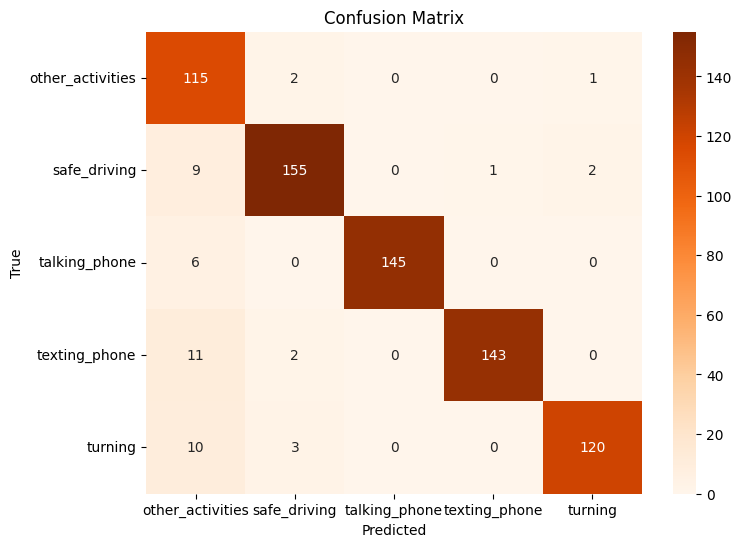

In [22]:
# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [23]:
# --- In kiến trúc mô hình ---
print("\nKiến trúc mô hình:")
print(model_loaded)


Kiến trúc mô hình:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size

In [24]:
# --- Tổng số tham số ---
total_params = sum(p.numel() for p in model_loaded.parameters())
trainable_params = sum(p.numel() for p in model_loaded.parameters() if p.requires_grad)
print(f"\nTổng số tham số: {total_params:,}")
print(f"Tham số huấn luyện được: {trainable_params:,}")


Tổng số tham số: 23,518,277
Tham số huấn luyện được: 23,518,277


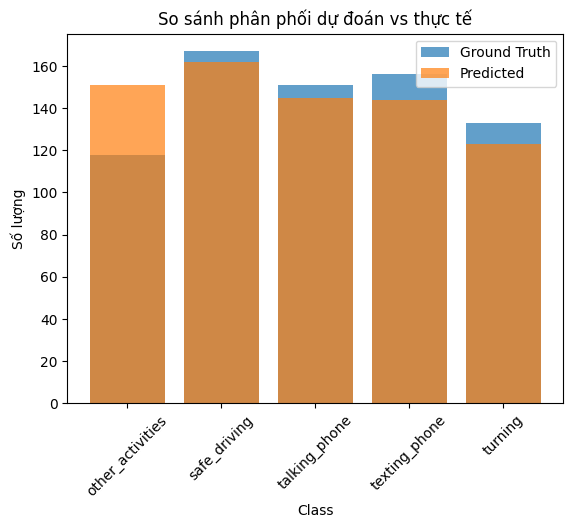

In [25]:
# --- So sánh phân phối dự đoán vs thực tế ---
pred_counts = collections.Counter(all_preds)
label_counts = collections.Counter(all_labels)

plt.bar(class_names, [label_counts[i] for i in range(len(class_names))], alpha=0.7, label="Ground Truth")
plt.bar(class_names, [pred_counts[i] for i in range(len(class_names))], alpha=0.7, label="Predicted")
plt.title("So sánh phân phối dự đoán vs thực tế")
plt.xlabel("Class")
plt.ylabel("Số lượng")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [26]:
# --- Thời gian dự đoán trung bình ---
def measure_inference_time(model, dataloader, n_batches=5):
    model.eval()
    total_time = 0.0
    with torch.no_grad():
        for i, (inputs, _) in enumerate(dataloader):
            if i >= n_batches:
                break
            inputs = inputs.to(device)
            start = time.time()
            _ = model(inputs)
            end = time.time()
            total_time += (end - start)
    avg_time = total_time / n_batches
    print(f"\nThời gian dự đoán trung bình (batch size={inputs.size(0)}): {avg_time:.4f} giây")
    return avg_time

measure_inference_time(model_loaded, val_loader)


Thời gian dự đoán trung bình (batch size=32): 0.1862 giây


0.18620223999023439

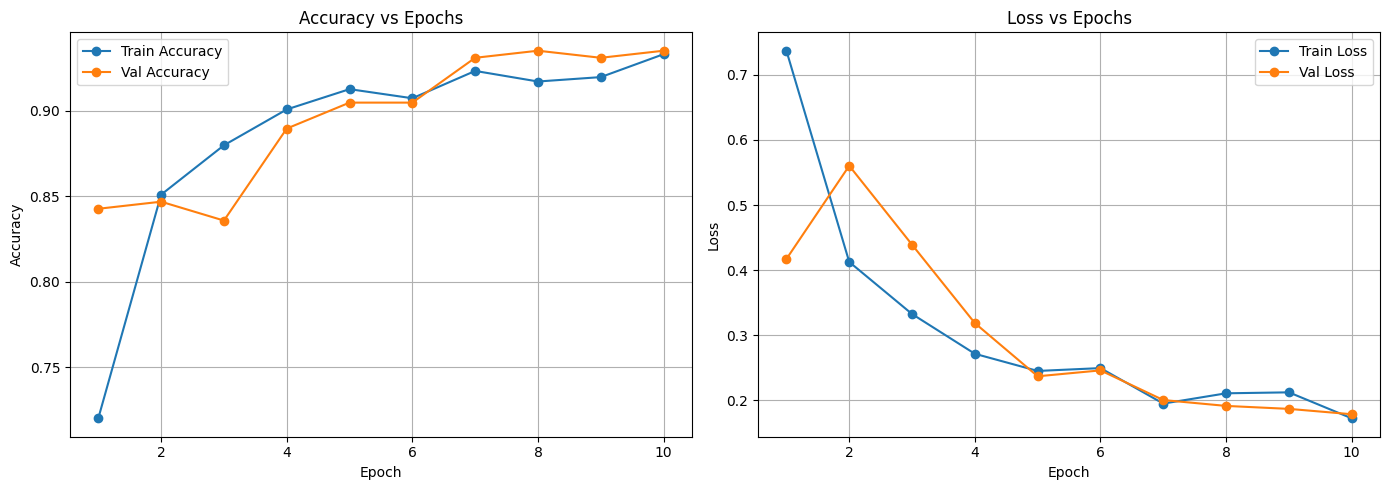

In [27]:


# --- Accuracy và Loss theo Epochs ---
epochs = range(1, len(train_accuracies) + 1)

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Val Accuracy', marker='o')
plt.title("Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker='o')
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [28]:
# --- MAP (Mean Average Precision) ---
map_score = precision_score(all_labels, all_preds, average='macro')
print(f"\nMean Average Precision (MAP - macro): {map_score:.4f}")


Mean Average Precision (MAP - macro): 0.9374
